In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModel

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv" 
BATCH_SIZE = 8   # Keep small for Audio-MAE
LEARNING_RATE = 2e-5 
EPOCHS = 20
BEST_MODEL_PATH = "best_dual_stream_model.pth"

print(f"🚀 Running on: {DEVICE}")

c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Running on: cuda


In [2]:
class VoicePathologyDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        
        # Physics Features
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        sfm_tensor = torch.tensor(norm_sfm, dtype=torch.float32)

        # Label
        label = torch.tensor(row['label_encoded'], dtype=torch.long)

        return file_path, sfm_tensor, label

# --- CUSTOM COLLATE FUNCTION ---
# Prevents PyTorch from crashing on List[String]
def custom_collate(batch):
    paths = [item[0] for item in batch] 
    sfms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return paths, sfms, labels

In [3]:
class DualStreamModel(nn.Module):
    def __init__(self, num_classes, sfm_dim=10, fusion_dim=512):
        super().__init__()
        
        print("🧠 Loading Hance-AI AudioMAE...")
        self.audio_encoder = AutoModel.from_pretrained(
            "hance-ai/audiomae", 
            trust_remote_code=True
        )
        self.audio_hidden_size = 768 
        self.audio_proj = nn.Linear(self.audio_hidden_size, fusion_dim)

        # Physics Stream (MLP)
        self.sfm_mlp = nn.Sequential(
            nn.Linear(sfm_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, fusion_dim),
            nn.LayerNorm(fusion_dim)
        )

        # Fusion (Cross-Attention)
        self.cross_attn = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=8, batch_first=True)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, audio_paths, sfm_input):
        # 1. Audio Stream (Loop Processing)
        audio_feats_list = []
        for path in audio_paths:
            # Encoder returns (768, 8, 64)
            feat = self.audio_encoder(path) 
            audio_feats_list.append(feat)
            
        # Stack & Send to GPU
        audio_feats = torch.stack(audio_feats_list)
        device = self.audio_proj.weight.device
        audio_feats = audio_feats.to(device) # <--- Critical Fix
        
        # Reshape: (Batch, 768, 8, 64) -> (Batch, 768, 512)
        batch_size = audio_feats.shape[0]
        audio_feats = audio_feats.view(batch_size, 768, -1).permute(0, 2, 1)
        
        # Project
        audio_emb = self.audio_proj(audio_feats) 

        # 2. Physics Stream
        sfm_emb = self.sfm_mlp(sfm_input) 
        sfm_query = sfm_emb.unsqueeze(1) 

        # 3. Fusion
        attn_out, attn_weights = self.cross_attn(
            query=sfm_query, 
            key=audio_emb, 
            value=audio_emb
        )
        
        fused_vector = attn_out.squeeze(1)
        logits = self.classifier(fused_vector)
        
        return logits, attn_weights

In [4]:
# 1. Load Data
full_df = pd.read_csv(SFM_CSV)

# 2. Encoders
label_encoder = LabelEncoder()
full_df['label_encoded'] = label_encoder.fit_transform(full_df['label_name'])
NUM_CLASSES = len(label_encoder.classes_)
print(f"✅ Classes: {label_encoder.classes_}")

# 3. Scalers
sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 
            'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
scaler = StandardScaler()
train_subset = full_df[full_df['split'] == 'train']
scaler.fit(train_subset[sfm_cols].values)

# 4. Loaders
train_ds = VoicePathologyDataset(full_df[full_df['split'] == 'train'], scaler, sfm_cols)
val_ds = VoicePathologyDataset(full_df[full_df['split'] == 'val'], scaler, sfm_cols)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

✅ Classes: ['Cysts_Structural' 'Dysarthia' 'Laryngitis' 'Vox senilis' 'parkinson'
 'spasmodische_dysphonie']


In [5]:
model = DualStreamModel(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

print("🔥 Starting Training...")
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    
    # --- TRAINING PHASE ---
    for paths, sfms, labels in train_loader:
        sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, _ = model(paths, sfms)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- VALIDATION PHASE ---
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for paths, sfms, labels in val_loader:
            sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
            
            logits, _ = model(paths, sfms)
            
            # Calculate Validation Loss
            v_loss = criterion(logits, labels)
            total_val_loss += v_loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # --- CHECKPOINTING ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"    💾 New Best Model Saved! ({val_acc:.4f})")

print(f"\n🏆 Training Complete. Best Validation Accuracy: {best_val_acc:.4f}")

🧠 Loading Hance-AI AudioMAE...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🔥 Starting Training...
Epoch 1/20 | Train Loss: 1.6626 | Val Loss: 1.3098 | Val Acc: 0.5745
    💾 New Best Model Saved! (0.5745)
Epoch 2/20 | Train Loss: 1.2973 | Val Loss: 0.8922 | Val Acc: 0.6538
    💾 New Best Model Saved! (0.6538)
Epoch 3/20 | Train Loss: 1.0825 | Val Loss: 0.8008 | Val Acc: 0.6923
    💾 New Best Model Saved! (0.6923)
Epoch 4/20 | Train Loss: 0.9849 | Val Loss: 0.7106 | Val Acc: 0.7067
    💾 New Best Model Saved! (0.7067)
Epoch 5/20 | Train Loss: 0.9006 | Val Loss: 0.6679 | Val Acc: 0.7452
    💾 New Best Model Saved! (0.7452)
Epoch 6/20 | Train Loss: 0.8260 | Val Loss: 0.6465 | Val Acc: 0.7212
Epoch 7/20 | Train Loss: 0.7605 | Val Loss: 0.5637 | Val Acc: 0.7837
    💾 New Best Model Saved! (0.7837)
Epoch 8/20 | Train Loss: 0.6885 | Val Loss: 0.5371 | Val Acc: 0.8029
    💾 New Best Model Saved! (0.8029)
Epoch 9/20 | Train Loss: 0.6308 | Val Loss: 0.4844 | Val Acc: 0.8149
    💾 New Best Model Saved! (0.8149)
Epoch 10/20 | Train Loss: 0.5830 | Val Loss: 0.4619 | Val Ac

🔄 Loading Best Model...
Path: processed_data\val\Cysts_Structural\1205-iau-egg_chunk0.wav
True Label: Cysts_Structural
Predicted:  Vox senilis


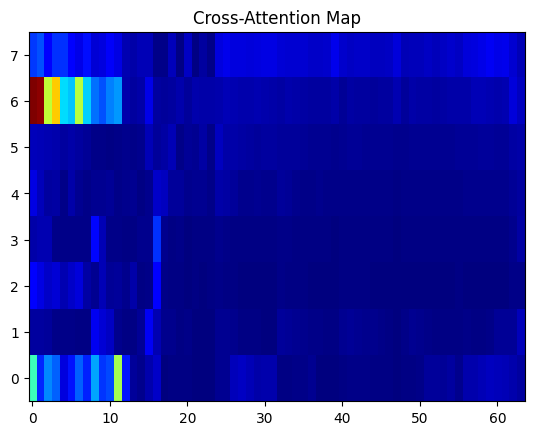

In [6]:
# Load the best saved weights
print("🔄 Loading Best Model...")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# Pick a sample
paths, sfms, labels = next(iter(val_loader))
idx = 0

# Predict
with torch.no_grad():
    logits, attn_weights = model([paths[idx]], sfms[idx].unsqueeze(0).to(DEVICE))
    pred_idx = torch.argmax(logits).item()

print(f"Path: {paths[idx]}")
print(f"True Label: {label_encoder.classes_[labels[idx]]}")
print(f"Predicted:  {label_encoder.classes_[pred_idx]}")

# Plot Attention
attn_map = attn_weights[0, 0, :].cpu().numpy().reshape(8, 64)
plt.imshow(attn_map, aspect='auto', cmap='jet', origin='lower')
plt.title("Cross-Attention Map")
plt.show()

🔄 Loading Best Saved Model...
🧠 Loading Hance-AI AudioMAE...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🚀 Running Evaluation on Test Set...

🏆 Final Test Accuracy: 85.68%

📝 Detailed Classification Report:
                        precision    recall  f1-score   support

      Cysts_Structural       0.52      0.50      0.51        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.58      0.74      0.65        42
           Vox senilis       0.85      0.83      0.84        93
             parkinson       0.96      0.96      0.96       200
spasmodische_dysphonie       0.45      0.25      0.32        20

              accuracy                           0.86       419
             macro avg       0.73      0.71      0.71       419
          weighted avg       0.85      0.86      0.85       419



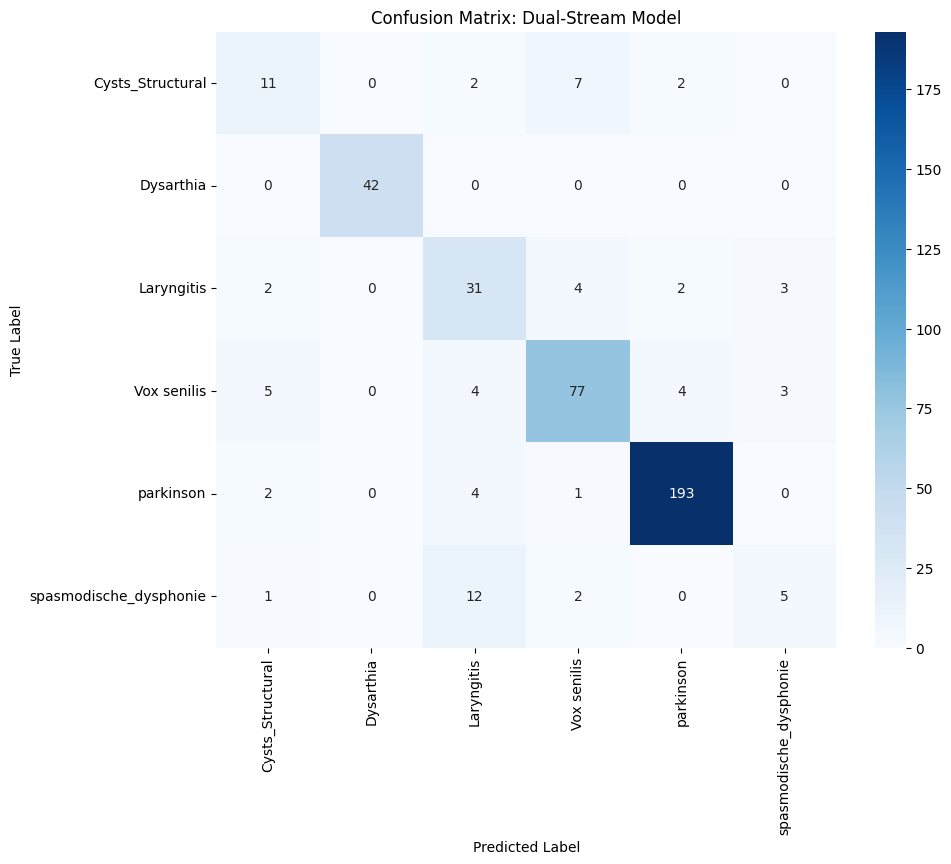

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Test Data
# We use the same scaler/encoder as training (Crucial!)
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

if len(test_df) == 0:
    print("⚠️ Warning: No 'test' split found in CSV. Using 'val' split instead.")
    test_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)

test_ds = VoicePathologyDataset(test_df, scaler, sfm_cols)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

# 2. Load the Best Model
print("🔄 Loading Best Saved Model...")
model = DualStreamModel(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# 3. Run Inference
all_preds = []
all_labels = []

print("🚀 Running Evaluation on Test Set...")
with torch.no_grad():
    for paths, sfms, labels in test_loader:
        sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        logits, _ = model(paths, sfms)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Metrics
acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 Final Test Accuracy: {acc*100:.2f}%")

# 5. Classification Report (Precision, Recall, F1)
class_names = label_encoder.classes_
print("\n📝 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 6. Confusion Matrix Heatmap
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Dual-Stream Model')
plt.show()

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Get all labels from training data
train_labels = full_df[full_df['split'] == 'train']['label_encoded'].values

# 2. Compute Weights (Inverse of frequency)
# "balanced" heuristic: n_samples / (n_classes * np.bincount(y))
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# 3. Convert to Tensor for PyTorch
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("⚖️ Calculated Class Weights:")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {name}: {class_weights[i]:.4f}")
# You should see high numbers (e.g., 5.0+) for Hyperfunctional and low numbers (0.5) for Parkinson

⚖️ Calculated Class Weights:
  Cysts_Structural: 1.9405
  Dysarthia: 1.0025
  Laryngitis: 0.9876
  Vox senilis: 0.6637
  parkinson: 0.6637
  spasmodische_dysphonie: 2.1688


In [9]:
# --- CONFIG FOR FINE-TUNING ---
# We use a slightly smaller LR for fine-tuning
FINE_TUNE_LR = 1e-5 
EPOCHS = 25

# 1. Weighted Loss Function (The Secret Sauce)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# 2. Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=FINE_TUNE_LR, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

print("🔥 Starting Weighted Fine-Tuning...")
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    
    # --- TRAINING ---
    for paths, sfms, labels in train_loader:
        sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, _ = model(paths, sfms)
        loss = criterion(logits, labels)
        
        loss.backward()
        # Gradient Clipping (Prevents exploding gradients in Transformers)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- VALIDATION ---
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for paths, sfms, labels in val_loader:
            sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
            
            logits, _ = model(paths, sfms)
            v_loss = criterion(logits, labels)
            total_val_loss += v_loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    
    # Step the scheduler (lower LR if accuracy stops improving)
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_weighted_model.pth")
        print(f"    💾 New Best Model Saved! ({val_acc:.4f})")

🔥 Starting Weighted Fine-Tuning...
Epoch 1/25 | Loss: 0.3631 | Val Loss: 0.4519 | Val Acc: 0.8558
    💾 New Best Model Saved! (0.8558)
Epoch 2/25 | Loss: 0.3442 | Val Loss: 0.4540 | Val Acc: 0.8582
    💾 New Best Model Saved! (0.8582)
Epoch 3/25 | Loss: 0.3275 | Val Loss: 0.4747 | Val Acc: 0.8654
    💾 New Best Model Saved! (0.8654)
Epoch 4/25 | Loss: 0.3180 | Val Loss: 0.4755 | Val Acc: 0.8630
Epoch 5/25 | Loss: 0.3172 | Val Loss: 0.4640 | Val Acc: 0.8678
    💾 New Best Model Saved! (0.8678)
Epoch 6/25 | Loss: 0.2988 | Val Loss: 0.5090 | Val Acc: 0.8582
Epoch 7/25 | Loss: 0.2784 | Val Loss: 0.5374 | Val Acc: 0.8606
Epoch 8/25 | Loss: 0.2779 | Val Loss: 0.5559 | Val Acc: 0.8534
Epoch 9/25 | Loss: 0.2829 | Val Loss: 0.5513 | Val Acc: 0.8702
    💾 New Best Model Saved! (0.8702)
Epoch 10/25 | Loss: 0.2623 | Val Loss: 0.5233 | Val Acc: 0.8726
    💾 New Best Model Saved! (0.8726)
Epoch 11/25 | Loss: 0.2506 | Val Loss: 0.5870 | Val Acc: 0.8702
Epoch 12/25 | Loss: 0.2561 | Val Loss: 0.6197 | 

KeyboardInterrupt: 

🔄 Loading Best Weighted Model...
🧠 Loading Hance-AI AudioMAE...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🚀 Running Evaluation on Test Set...

🏆 Final Test Accuracy: 86.40%

📝 Detailed Classification Report:
                        precision    recall  f1-score   support

      Cysts_Structural       0.54      0.59      0.57        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.61      0.74      0.67        42
           Vox senilis       0.84      0.86      0.85        93
             parkinson       0.97      0.94      0.95       200
spasmodische_dysphonie       0.62      0.40      0.48        20

              accuracy                           0.86       419
             macro avg       0.76      0.75      0.75       419
          weighted avg       0.87      0.86      0.86       419



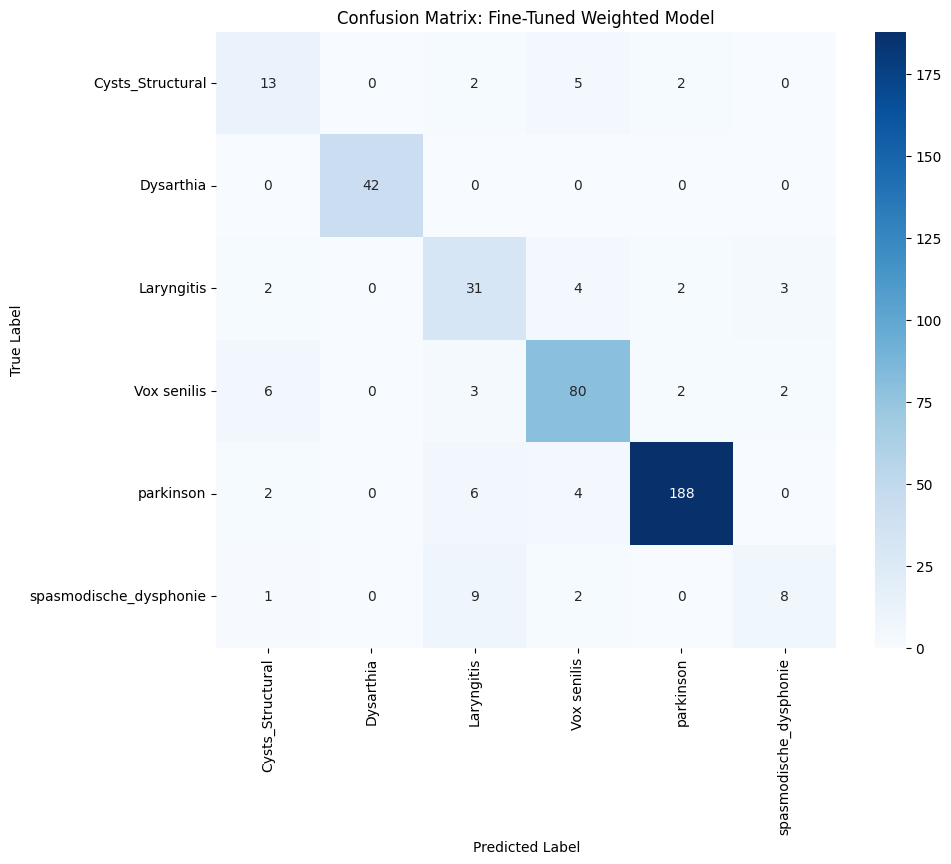

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Test Data
# (Ensuring we use the same scaler/encoder as training)
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

if len(test_df) == 0:
    print("⚠️ Warning: No 'test' split found. Using 'val' split instead.")
    test_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)

test_ds = VoicePathologyDataset(test_df, scaler, sfm_cols)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

# 2. Load the FINE-TUNED Model
# Note: We are loading "best_weighted_model.pth" this time
print("🔄 Loading Best Weighted Model...")
model = DualStreamModel(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("best_weighted_model.pth"))
model.eval()

# 3. Run Inference
all_preds = []
all_labels = []

print("🚀 Running Evaluation on Test Set...")
with torch.no_grad():
    for paths, sfms, labels in test_loader:
        sfms, labels = sfms.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        logits, _ = model(paths, sfms)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Metrics
acc = accuracy_score(all_labels, all_preds)
print(f"\n🏆 Final Test Accuracy: {acc*100:.2f}%")

# 5. Classification Report
# Look specifically at 'Hyperfunctional' and 'Laryngitis' rows to see improvement
class_names = label_encoder.classes_
print("\n📝 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 6. Confusion Matrix Heatmap
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Fine-Tuned Weighted Model')
plt.show()